In [1]:
import sys
sys.path.append('../')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, QuantileTransformer

import xgboost as xgb
from skopt import BayesSearchCV

import tensorflow as tf

/home/hardian_lawi/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
pd.options.display.max_columns = 100
%matplotlib inline
# tf.enable_eager_execution()

plt.style.use('seaborn')

In [3]:
radiant_cols = ['hero_' + str(i) for i in range(5)]
dire_cols = ['hero_' + str(i) for i in range(5, 10)]
no_heroes = 116

filter_cols = ['base_mr']

cont_variables = [
    'agi_gain',
    'attack_range',
    'attack_rate',
    'base_agi',
    'base_armor',
    'base_attack_max',
    'base_attack_min',
    'base_health_regen',
    'base_int',
    'base_mr',
    'base_str',
    'int_gain',
    'legs',
    'move_speed',
    'pro_ban',
    'pro_pick',
    'pro_win',
    'projectile_speed',
    'str_gain',
    'turn_rate',
]

unique_roles = [
    'Carry',
    'Disabler',
    'Durable',
    'Escape',
    'Initiator',
    'Jungler',
    'Nuker',
    'Pusher',
    'Support'
]

unique_primary_attrs = [
    'agi',
    'int',
    'str'
]

feature_names = cont_variables + \
    ['min_' + col for col in cont_variables if col not in filter_cols] + \
    ['max_' + col for col in cont_variables if col not in filter_cols] +  [
    'no_agi',
    'no_int',
    'no_str',
    'no_melees',
    'no_Carry',
    'no_Disabler',
    'no_Durable',
    'no_Escape',
    'no_Initiator',
    'no_Jungler',
    'no_Nuker',
    'no_Pusher',
    'no_Support',
]

def load_data():
    
    df = pd.read_csv('../data/matches_data.csv')
    radiants = pd.read_csv('../data/radiant_features.csv')
    dires = pd.read_csv('../data/dire_features.csv')
    
    assert np.all(radiants.columns == dires.columns), 'Radiants have different features than dires'
    assert df.shape[0] == radiants.shape[0], 'Number of matches in radiants are different to original matches data'
    assert df.shape[0] == dires.shape[0], 'Number of matches in dires are different to original matches data'
    assert len(feature_names) + 1 == radiants.shape[1]
    assert len(feature_names) + 1 == dires.shape[1]
    assert (radiants['match_id'] == dires['match_id']).all()
    assert (radiants['match_id'] == df['match_id']).all()
    
    radiants = radiants.\
        rename({col: 'radiant_' + col for col in feature_names}, axis=1).\
        drop('match_id', axis=1)
    dires = dires.\
        rename({col: 'dire_' + col for col in feature_names}, axis=1).\
        drop('match_id', axis=1)
    df = pd.concat([df[['match_id', 'radiant_win']], radiants, dires], axis=1)
    return radiants, dires, df

In [4]:
radiants, dires, df = load_data()

In [5]:
n_splits = 5
kf = KFold(n_splits, shuffle=True, random_state=10)

print('=================================================')

avg_score = {}
scores = []
avg_threshold = 0

k_values = range(5, 250, 2)

for k in k_values:
    
    print(k, ' ', end='')
    
    model = KNeighborsClassifier(k, n_jobs=-1)
    
    score = 0
    
    for i, (train_idx, test_idx) in enumerate(kf.split(df)):

        X_train = np.concatenate([radiants.iloc[train_idx].copy(), dires.iloc[train_idx].copy()], axis=1)
        X_test = np.concatenate([radiants.iloc[test_idx].copy(), dires.iloc[test_idx].copy()], axis=1)

        y_train = df.radiant_win.iloc[train_idx].values
        y_test = df.radiant_win.iloc[test_idx].values
        
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        model.fit(X_train, y_train)
        
        score += accuracy_score(y_test, model.predict(X_test))
        
    score /= n_splits
    
    scores.append(score)
    
print('\nDone.')
          
############################################################################

# print('Avg threshold', avg_threshold / (n_splits * len(models_dict)), '\n\n')
# print('Number of features:', len(feature_columns))
# print('Features:', feature_columns, '\n\n')

5  7  9  11  13  15  17  19  21  23  25  27  29  31  33  35  37  39  41  43  45  47  49  51  53  55  57  59  61  63  65  67  69  71  73  75  77  79  81  83  85  87  89  91  93  95  97  99  101  103  105  107  109  111  113  115  117  119  121  123  125  127  129  131  133  135  137  139  141  143  145  147  149  151  153  155  157  159  161  163  165  167  169  171  173  175  177  179  181  183  185  187  189  191  193  195  197  199  201  203  205  207  209  211  213  215  217  219  221  223  225  227  229  231  233  235  237  239  241  243  245  247  249  
Done.


Text(0.5, 1.0, 'Accuracy score of KNN with different K sizes')

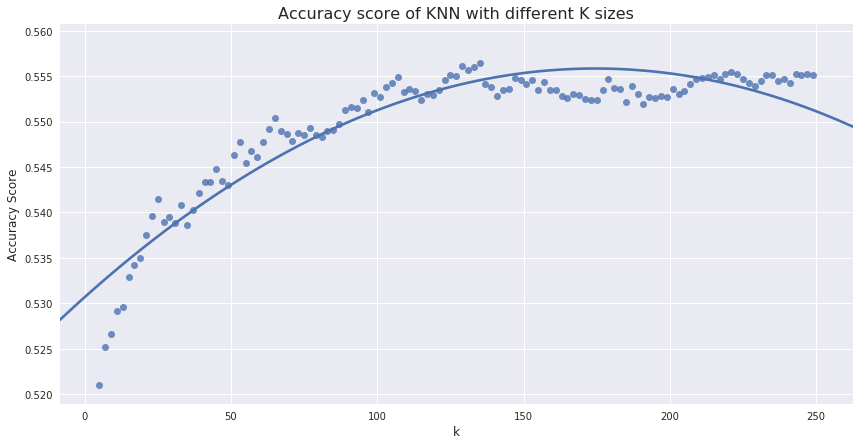

In [6]:
df = pd.DataFrame(list(zip(k_values, scores)), columns=['k', 'score'])
sns.lmplot(x='k', y='score', data=df, height=6, aspect=2, ci=None, order=2)
plt.ylabel('Accuracy Score', fontsize=12)
plt.xlabel('k', fontsize=12)
plt.title('Accuracy score of KNN with different K sizes', fontsize=16)

In [7]:
df.to_csv('knn_validations', index=False)

In [9]:
df

,k,score
0,5,0.521027
1,7,0.525241
2,9,0.526580
3,11,0.529120
4,13,0.529594
5,15,0.532859
6,17,0.534226
7,19,0.535008
8,21,0.537519
9,23,0.539640


In [10]:
print('Maximum k', df.iloc[df.score.argmax()])

Maximum k k        135.000000
score      0.556411
Name: 65, dtype: float64


/home/hardian_lawi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  """Entry point for launching an IPython kernel.
